In [1]:
!pip install scikit-image
!pip install opencv-python
!pip install imutils

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib
from skimage.feature import canny
from skimage.filters import median
from matplotlib import pyplot as plt
from skimage.measure import label   
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
import csv
from skimage import io
%matplotlib inline
from skimage.feature import graycomatrix, graycoprops
from skimage import data
from skimage.color import rgb2gray
import imutils
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import collections
import seaborn as sns

**Define Functions**

In [6]:
def tumor_part(c):
    area = cv2.contourArea(c)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    if hull_area!=0:
        solidity = float(area)/hull_area
    else:
        solidity=0
    # print(solidity,area)
    if solidity>0.5 and area>2000:
        # print(area)
        return True
    else:
        return False

def blur_image(img):
    # blur = cv2.GaussianBlur(img,(5,5),0)
    # blur=cv2.bilateralFilter(img,9,75,75)
    kernel = np.ones((5,5),np.float32)/25
    blur = cv2.filter2D(img,-1,kernel)
    return blur


def enhance(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    gray = cv2.equalizeHist(img)
    # gray = clahe.apply(blur)
    return gray

def threshold(img,b):
    ret,thresh = cv2.threshold(img,b,255,cv2.THRESH_BINARY)

    return thresh

def contours(img,org,b):
    img2 = threshold(img,b)
    cnts = cv2.findContours(img2.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    img2 = RGB(img2)
    org = RGB(org)
    for (i,c) in enumerate(cnts):
        if tumor_part(c):
            cv2.drawContours(org, [c], -1, (1,255,11), 2)
            cv2.drawContours(img2, [c], -1, (1,255,11), 2)
    return (org,img2)

def RGB(img):
    return cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

def k_means(img):
    Z = img.reshape((-1,1))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 8
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

def edge_ex(img):
    return cv2.Canny(img,100,200)

def show_images(gray,blur,seg,cont_org,cont_mask):
    res1 =  np.hstack((blur,seg))
    res2 =  np.hstack((cont_org,cont_mask))
    res = np.vstack((res1,res2))
    cv2.imwrite("/content/drive/MyDrive/BrainTumurDiagnosis/result_kmean.jpg",res)
    cv2.imshow("image",res)

def process(img3,b):
    gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    blur = blur_image(gray)
    seg = k_means(blur)
    cont_org, cont_mask = contours(seg,gray,b)
    seg = RGB(seg)
    blur = RGB(blur)
    gray = RGB(gray)
    show_images(gray,blur,seg,cont_org,cont_mask)

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def Tumor_Segmentation (InputImg):
  org = InputImg.copy()
  gray = cv2.cvtColor(InputImg, cv2.COLOR_BGR2GRAY)
  blur = blur_image(gray)
  seg = k_means(blur)
  cont_org, cont_mask = contours(seg,gray,100)
  seg = RGB(seg)
  blur = RGB(blur)
  gray = RGB(gray)
  res1 =  np.hstack((blur,seg))
  res2 =  np.hstack((cont_org,cont_mask))
  res = np.vstack((res1,res2))
  cont_mask  = cv2.cvtColor(cont_mask, cv2.COLOR_BGR2GRAY)
  Tumor = getLargestCC(cont_mask)
  return Tumor 

def LBP_Extraction(InputImg):  
    radius = 2
    n_points = 8 * radius 
    # sampling type for LBP
    METHOD = 'uniform'       
    lbp = local_binary_pattern(InputImg, n_points, radius, METHOD)
    lbp_hist,_ = np.histogram(lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    a1 , a2, a3, a4, a5 , a6, a7,a8 =lbp_prob
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))  
    lbphist_features = np.reshape(np.array(lbp_hist).ravel(),(1,len(np.array(lbp_hist).ravel())))
    lbpprob_features=np.reshape(np.array(lbp_prob).ravel(),(1,len(np.array(lbp_prob).ravel())))
    lbpenrgy_features=np.reshape(np.array(lbp_energy).ravel(),(1,len(np.array(lbp_energy).ravel())))
    lbpento_features=np.reshape(np.array(lbp_entropy).ravel(),(1,len(np.array(lbp_entropy).ravel())))
    lbp_features1=np.concatenate ((lbphist_features,lbpprob_features))
    lbp_features2=np.concatenate ((lbpenrgy_features,lbpento_features))
    lbp_features = np.concatenate ((lbp_features1,lbp_features2) , axis = 1)
    return a3, a4, a5 , a6, a7,a8,lbp_energy  #lbphist_features,lbpprob_features

def GLCM_Extraction(InputImg):  
  gCoMat = graycomatrix(InputImg, [1], [0],256,symmetric=True, normed=True)
  contrast = graycoprops(gCoMat, prop='contrast')
  dissimilarity = graycoprops(gCoMat, prop='dissimilarity')
  homogeneity = graycoprops(gCoMat, prop='homogeneity')    
  ASM = graycoprops(gCoMat, 'ASM')
  energy = graycoprops(gCoMat, prop='energy')
  correlation = graycoprops(gCoMat, prop='correlation')    
  contrast_features = np.reshape(np.array(contrast).ravel(),(1,len(np.array(contrast).ravel())))
  dissimilarity_features=np.reshape(np.array(dissimilarity).ravel(),(1,len(np.array(dissimilarity).ravel())))
  homogeneity_features=np.reshape(np.array(homogeneity).ravel(),(1,len(np.array(homogeneity).ravel())))
  energy_features=np.reshape(np.array(energy).ravel(),(1,len(np.array(energy).ravel())))
  correlation_features=np.reshape(np.array(correlation).ravel(),(1,len(np.array(correlation).ravel())))
  con_1 = np.concatenate((contrast_features,dissimilarity_features,homogeneity_features))
  glcm_features=np.concatenate((con_1,energy_features,correlation_features))  
  return contrast, homogeneity, ASM, energy,correlation

    
def Preprocess_Func (InputImg):
  InputImg = cv2.cvtColor(InputImg,cv2.COLOR_BGR2GRAY)
  resized_img = cv2.resize(InputImg, (256, 256)) 
  enhanced_img = cv2.medianBlur(resized_img, 5)
  return enhanced_img

def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]


**Load Train Data**

In [23]:
image_directory_train='/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Train/'
no_tumor_images=os.listdir(image_directory_train+'no/')
yes_tumor_images=os.listdir(image_directory_train+'yes/')
dataset_img=[]
feature_train = []
L=[]
print("Number of No Tumor Images:",len(no_tumor_images))
print("Number of Tumor Images",len(yes_tumor_images))
path = os.listdir(image_directory_train)
classes = {'no': 0, 'yes': 1}

Number of No Tumor Images: 95
Number of Tumor Images 155


In [24]:
X, Y = [], []
feature_train = []
image_directory = '/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Train/'
for cls in classes:
    pth = '/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Train/'+cls+'/'
    for i,image_name in enumerate(os.listdir(pth)):
      if(image_name.split('.')[1]=='jpg'):
        PATH = image_directory+cls+'/'+image_name
        image = cv2.imread(PATH)
        image_enhanced =Preprocess_Func (image)
        l1 , l2, l3, l4, l5 , l6, l7 = LBP_Extraction(image_enhanced)
        lbp1 = l1.tolist()
        lbp2 = l2.tolist()
        lbp3 = l3.tolist()
        lbp4 = l4.tolist()
        lbp5 = l5.tolist()
        lbp6 = l6.tolist()
        lbp7 = l7.tolist()
        List_LBP = [lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7]
       # contrast, homogeneity, ASM, energy ,correlation = GLCM_Extraction(image_enhanced)
        Tumor_part = Tumor_Segmentation (image)
        contrast, homogeneity, ASM, energy,correlation =GLCM_Extraction(Tumor_part)
        contrast_1 = contrast.tolist()
        contrast_2=contrast_1[0][0]
        homogeneity_1 = homogeneity.tolist()
        homogeneity_2= homogeneity_1[0][0]
        ASM_1 = ASM.tolist()
        ASM_2= ASM_1[0][0]
        energy_1 = energy.tolist()
        energy_2= energy_1[0][0]
        correlation_1 = correlation.tolist()
        correlation_2= correlation_1[0][0]
        List_GLCM = [contrast_2, homogeneity_2,ASM_2,energy_2,correlation_2]
        dataset_img.append(np.array(image).flatten())
        feature_train.append (List_GLCM +List_LBP)
        if (cls == 'no'):
          L.append(0)
        else:
          L.append(1)

**Convert numpy array to pandas dataframe**

In [25]:
# Shuffle the data
feature_train, L = shuffle(feature_train, L)

In [26]:
feat_array_full = np.array(feature_train)
Train_df = pd.DataFrame(feature_train)
Train_df.columns = [ 'contrast', 'homogeneity','ASM','energy','correlation','LBP_1','LBP_2','LBP_3','LBP_4' ,'LBP_5', 'LBP_6','LBP_7']
Train_df.info
Train_df.shape

(186, 12)

In [39]:
Train_df.head()

,contrast,homogeneity,ASM,energy,correlation,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7
0,0.008265,0.995867,0.864483,0.929776,0.935083,0.061829,0.242722,0.177002,0.081940,0.044769,0.337006,0.217877
1,0.008675,0.995662,0.772577,0.878964,0.960356,0.073029,0.260986,0.146240,0.064941,0.035187,0.352112,0.226586
2,0.014644,0.992678,0.897591,0.947413,0.833556,0.054947,0.194839,0.139191,0.079773,0.050064,0.418228,0.246131
3,0.001872,0.999064,0.870000,0.932738,0.985386,0.058853,0.193405,0.120255,0.046600,0.024826,0.502747,0.312310
4,0.011066,0.994467,0.818711,0.904827,0.935038,0.055420,0.202530,0.146591,0.076004,0.042740,0.424240,0.254545


In [27]:
# write dataframe to .csv file
data_dir = '/content/drive/MyDrive/BrainTumurDiagnosis'
Train_df.to_csv(data_dir + 'Features Dataframe.csv')

In [28]:
y_train = L
y_train = np.array(y_train)

**Load Test Data**

In [29]:
X, Y = [], []
Test_feature = []
L_test = []
image_directory = '/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Test/'
for cls in classes:
    for i,image_name in enumerate(os.listdir(image_directory)):
      if(image_name.split('.')[1]=='jpg'):
        PATH = image_directory+image_name
        image = cv2.imread(PATH)
        image_enhanced =Preprocess_Func (image)
        l1 , l2, l3, l4, l5 , l6, l7 = LBP_Extraction(image_enhanced)
        lbp1 = l1.tolist()
        lbp2 = l2.tolist()
        lbp3 = l3.tolist()
        lbp4 = l4.tolist()
        lbp5 = l5.tolist()
        lbp6 = l6.tolist()
        lbp7 = l7.tolist()
        List_LBP = [lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7]
       # contrast, homogeneity, ASM, energy ,correlation = GLCM_Extraction(image_enhanced)
        Tumor_part = Tumor_Segmentation (image)
        contrast, homogeneity, ASM, energy,correlation =GLCM_Extraction(Tumor_part)
        contrast_1 = contrast.tolist()
        contrast_2=contrast_1[0][0]
        homogeneity_1 = homogeneity.tolist()
        homogeneity_2= homogeneity_1[0][0]
        ASM_1 = ASM.tolist()
        ASM_2= ASM_1[0][0]
        energy_1 = energy.tolist()
        energy_2= energy_1[0][0]
        correlation_1 = correlation.tolist()
        correlation_2= correlation_1[0][0]
        List_GLCM = [contrast_2, homogeneity_2,ASM_2,energy_2,correlation_2]
        dataset_img.append(np.array(image).flatten())
        Test_feature.append (List_GLCM +List_LBP)
        if 'No' in image_name:
          L_test.append(0)
        else:
          L_test.append(1)

In [30]:
clf = SVC (kernel='linear' , random_state=10)
clf.fit(Train_df, y_train)


SVC(kernel='linear', random_state=10)

In [31]:
y_pred = clf.predict(Test_feature)
print("Acc = ", metrics.accuracy_score(L_test,y_pred)*100,"%")

Acc =  90.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


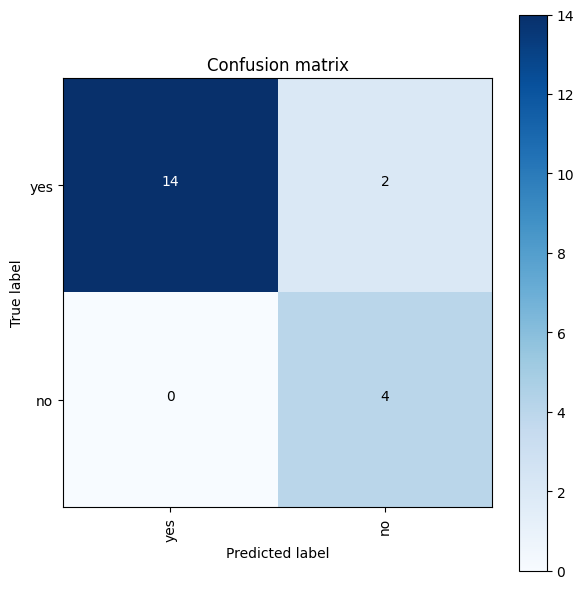

In [33]:
labels = ['yes','no']
confusion_mtx = confusion_matrix(L_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr

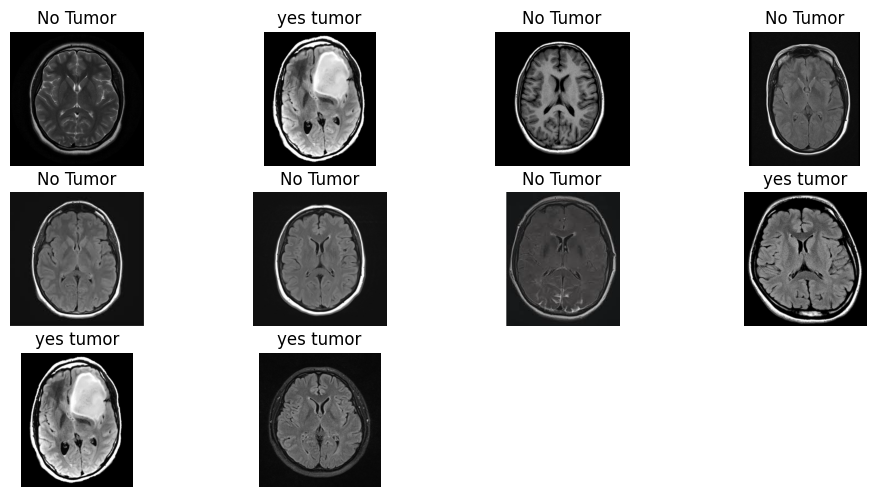

In [34]:
dir='/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Test/'
c=1
plt.figure(figsize = (12,8))
Test_featuress = []
for i,image_name in enumerate(os.listdir(dir)):
      if(image_name.split('.')[1]=='jpg'):
        test=[]
        PATH = dir+image_name
        image = cv2.imread(PATH)
        plt.subplot(4,4,c)
        image_enhanced =Preprocess_Func (image)
        l1 , l2, l3, l4, l5 , l6, l7 = LBP_Extraction(image_enhanced)
        lbp1 = l1.tolist()
        lbp2 = l2.tolist()
        lbp3 = l3.tolist()
        lbp4 = l4.tolist()
        lbp5 = l5.tolist()
        lbp6 = l6.tolist()
        lbp7 = l7.tolist()
        List_LBP = [lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7]
       # contrast, homogeneity, ASM, energy ,correlation = GLCM_Extraction(image_enhanced)
        Tumor_part = Tumor_Segmentation (image)
        contrast, homogeneity, ASM, energy,correlation =GLCM_Extraction(Tumor_part)
        contrast_1 = contrast.tolist()
        contrast_2=contrast_1[0][0]
        homogeneity_1 = homogeneity.tolist()
        homogeneity_2= homogeneity_1[0][0]
        ASM_1 = ASM.tolist()
        ASM_2= ASM_1[0][0]
        energy_1 = energy.tolist()
        energy_2= energy_1[0][0]
        correlation_1 = correlation.tolist()
        correlation_2= correlation_1[0][0]
        List_GLCM = [contrast_2, homogeneity_2,ASM_2,energy_2,correlation_2]
        dataset_img.append(np.array(image).flatten())
        Test_featuress = (List_GLCM +List_LBP)
       # Test_featuress = pd.DataFrame(Test_featuress)
        pred=clf.predict([Test_featuress])
    # plt.title(dict[i])
        if(pred==0):
          plt.title('No Tumor')
        elif(pred==1):
          plt.title("yes tumor")
        else:
         plt.title("irrelevant")
        plt.imshow(image,cmap='gray')
        plt.axis('off')
        c+=1

**ELM Classifire**

In [35]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) # mean of the elements that are equal
    
def softmax(x):
    
    max = np.max(x, axis=1, keepdims=True) # Returns max of each row and keeps same dims
    e_x = np.exp(x - max) # Subtracts each row with its max value
    sum = np.sum(e_x, axis=1, keepdims=True) # Returns sum of each row and keeps same dims
    f_x = e_x / sum
    
    return f_x

class ELMClassifier():

    def __init__(self, L, random_state=None):
        
        self.L = L # number of hidden neurons
        self.random_state = random_state # random state

    def fit(self, X, y=None):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        np.random.seed(seed=self.random_state) # set random seed

        self.w1 = np.random.uniform(low=-1, high=1, size=(self.L, N+1)) # Weights with bias

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        # One-hot encoding
        n_classes = len(np.unique(y))
        y = np.eye(n_classes)[y]

        self.w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D

        return self

    def predict(self, X):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        y_pred = softmax(Ha.dot(self.w2.T)) # Predictions
        
        # Revert one-hot encoding
        y_pred = np.argmax(y_pred, axis=1) # axis=1 means that we want to find the index of the maximum value in each row

        return y_pred

    def predict_proba(self, X):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        y_pred = softmax(Ha.dot(self.w2.T)) # Predictions

        return y_pred

In [36]:
elm = ELMClassifier(L=82, random_state=42) # ELM
elm.fit(Train_df, L) # Train

In [37]:
y_train_pred = elm.predict(Train_df) # Train predictions
y_test_pred = elm.predict(Test_feature) # Test predictions
y_test_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [38]:
train_acc = accuracy(L, y_train_pred)
test_acc = accuracy(L_test, y_test_pred)

print('Training accuracy (%):', train_acc*100)
print('Testing accuracy (%):', test_acc*100)

Training accuracy (%): 94.6236559139785
Testing accuracy (%): 90.0


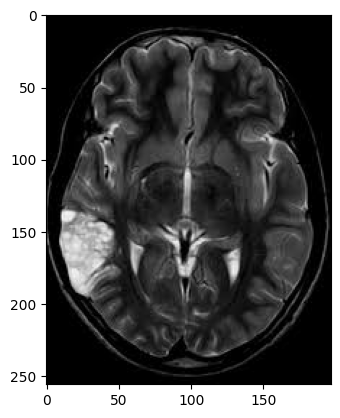

In [20]:
img = cv2.imread('/content/drive/MyDrive/BrainTumurDiagnosis/Dataset/Train/yes/Y72.jpg')
plt.imshow(img)

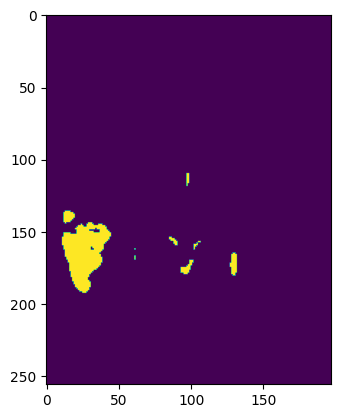

In [21]:
org = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = blur_image(gray)
seg = k_means(blur)
cont_org, cont_mask = contours(seg,gray,150)
seg = RGB(seg)
blur = RGB(blur)
gray = RGB(gray)
res1 =  np.hstack((blur,seg))
res2 =  np.hstack((cont_org,cont_mask))
res = np.vstack((res1,res2))
plt.imshow (cont_mask)

cont_mask  = cv2.cvtColor(cont_mask, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(cont_mask,0,255,cv2.THRESH_OTSU)
ret, markers = cv2.connectedComponents(thresh)
largest_component = np.argmax(cont_mask)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

plt.imshow(cont_mask)

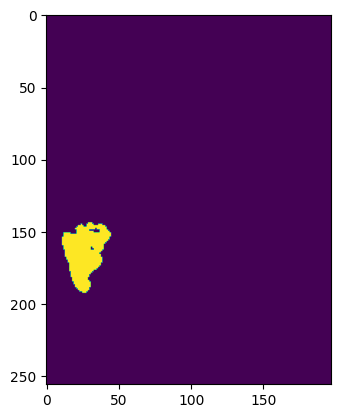

In [22]:
a = getLargestCC(cont_mask)
plt.imshow (a)